In [21]:
import time 
import math
import numpy as np 
import pandas as pd 
import scipy as sc 
import matplotlib.pyplot as plt 
import yfinance as yf 
import datetime 
from IPython.display import display, Latex 
from statsmodels.graphics.tsaplots import plot_acf 

In [22]:
#import data

def get_data(stocks, start, end ):
    df = yf.download(stocks, start= startDate, end= endDate)
    return df

endDate = datetime.datetime.now()
startDate = endDate - datetime.timedelta(days = 7000)

stock_prices = get_data("SPY", startDate, endDate)
print(startDate)
stock_prices.head()

[*********************100%***********************]  1 of 1 completed
2004-01-19 21:26:56.775535


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-01-20,114.529999,114.650002,113.820000,114.199997,78.774696,29863000
2004-01-21,114.129997,115.300003,113.720001,115.099998,79.395523,30725000
2004-01-22,115.139999,115.379997,114.580002,114.800003,79.188560,29888500
2004-01-23,115.000000,115.370003,113.949997,114.430000,78.933365,44245300
2004-01-26,114.389999,115.930000,114.379997,115.870003,79.926689,30460600


<h2>Volatility clustering in financial time series<h2>

<h4> The study of statistical properties financial time series<h4>
<p>
- Excess volatility 
- Heavy Tails 
- Volatility Clustering
<p>
<h5>As noted large changes tend to be followed by other large changes. 
Small changes tend to be followed by other small changes<h5>

rt=Xt+Δ–Xt=ln(St+ΔSt)

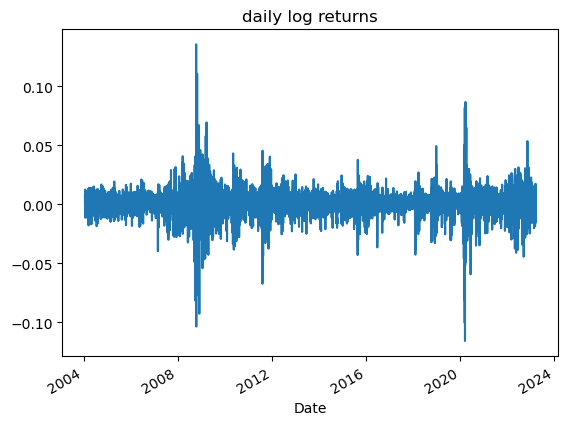

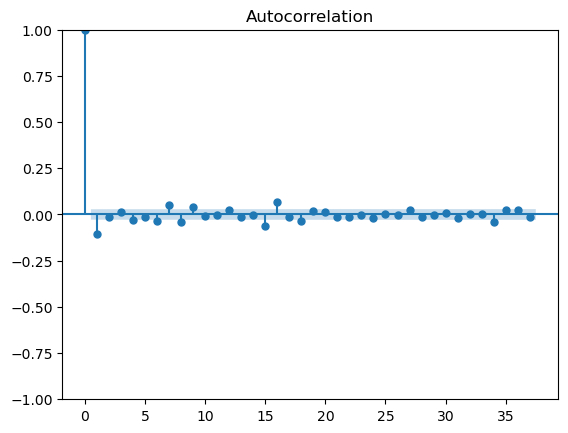

In [23]:
log_returns = np.log(stock_prices.Close/stock_prices.Close.shift(1)).dropna()
log_returns.plot()
plt.title("daily log returns")
plot_acf(log_returns)
plt.show()

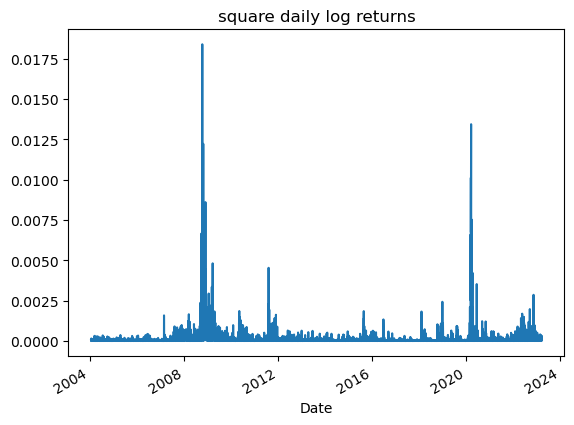

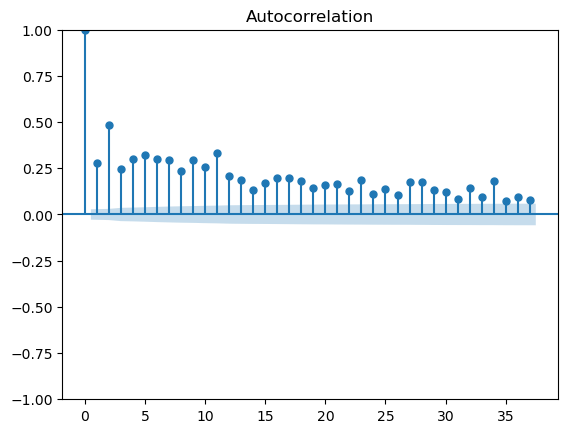

In [24]:
log_returns_sq = np.square(log_returns)
log_returns_sq.plot()
plt.title("square daily log returns")
plot_acf(log_returns_sq)
plt.show()

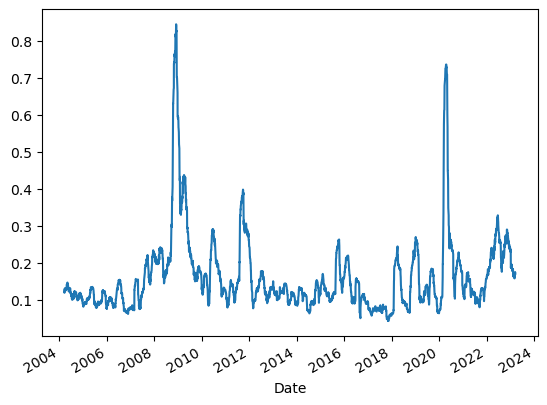

In [25]:
# Realized Volatility

TRADING_DAYS = 40
volatility = log_returns.rolling(window = TRADING_DAYS).std()*np.sqrt(252)
volatility = volatility.dropna()
volatility.plot()
plt.show()

<h2>Ornstein-Uhlenbeck</h2>
<p>Ornstein-Uhlenbeck is a stochastic process that is a stationary Gauss-Markov process.</p>
<h3>dXt=−κXtdt+σdWt</h3>
<p>Sometimes, an additional drift term is sometimes added – this is known as the Vasicek model:</p>
<h3>dXt=κ(θ−Xt)dt+σdWt</h3>

In [26]:
def MLE_norm(x):
    mu_hat = np.mean(x)
    sigma2_hat = np.var(x)
    return mu_hat, sigma2_hat

In [27]:
mu = 5
sigma = 2.5
N = 10000

np.random.seed(0)
x = np.random.normal(loc=mu, scale = sigma, size = (N,))

mu_hat, sigma2_hat = MLE_norm(x)

for_mu_hat = "$\hat{\mu}" + format(round(mu_hat,2))+ "$"
for_sigma_hat = "$\hat{\sigma}" + format(round(np.sqrt(sigma2_hat),2))+ "$"


print("The MLE for data is ")
display(Latex(for_mu_hat))
display(Latex(for_sigma_hat))

The MLE for data is 


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [28]:
def log_likelihood(theta, x):
    mu = theta[0]
    sigma = theta[1]
    
    l_theta = np.sum(np.log(sc.stats.norm.pdf(x, loc = mu, scale = sigma)))
    
    return -l_theta

def sigma_pos(theta):
    sigma = theta[1]
    return sigma

In [29]:
cons_set = {"type":"ineq","fun": sigma_pos}

theta0 = [2,3]
opt  = sc.optimize.minimize(fun = log_likelihood, x0=theta0, args=(x,), constraints= cons_set)


for_mu_hat = "$\hat{\mu}" + format(round(mu_hat,2))+ "$"
for_sigma_hat = "$\hat{\sigma}" + format(round(np.sqrt(sigma2_hat),2))+ "$"


print("The MLE for data is ")
display(Latex(for_mu_hat))
display(Latex(for_sigma_hat))

The MLE for data is 


/var/folders/_f/lm78gx9j0yzd5whlktz22zjm0000gn/T/ipykernel_25125/3728294269.py:5: RuntimeWarning: divide by zero encountered in log
  l_theta = np.sum(np.log(sc.stats.norm.pdf(x, loc = mu, scale = sigma)))


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [30]:
def mu(x, dt, kappa, theta):
    ekt = np.exp(-kappa*dt)
    return x*ekt + theta*(1-ekt)

def std(dt, kappa, sigma):
    e2kt = np.exp(-2*kappa*dt)
    return sigma*np.sqrt((1-e2kt)/(2*kappa))

In [31]:
def log_likelihood_OU(theta_hat, x):
    kappa = theta_hat[0]
    theta = theta_hat[1]
    
    
    x_dt = x[1:]
    x_t = x[:-1]
    
    dt = 1/252
    
    mu_OU = mu(x_t, dt, kappa, theta)
    sigma_OU = std(dt,kappa,sigma)
    
    l_theta_hat = np.sum(np.log(sc.stats.norm.pdf(x_dt, loc = mu_OU, scale = sigma_OU)))
    
    return -l_theta_hat

def kappa_pos(theta_hat):
    kappa =  theta_hat[0]
    return kappa

def sigma_pos(theta_hat):
    sigma = theta_hat[2]
    return sigma    

In [32]:
vol = np.array(volatility)

In [33]:
cons_set = [{"type":"ineq", "fun": kappa_pos},
            {"type":"ineq", "fun": sigma_pos}]

theta0 = [1,1,1]
opt = sc.optimize.minimize(fun = log_likelihood_OU, x0 = theta0, args=(vol,), constraints= cons_set)

opt

/var/folders/_f/lm78gx9j0yzd5whlktz22zjm0000gn/T/ipykernel_25125/2558552584.py:14: RuntimeWarning: divide by zero encountered in log
  l_theta_hat = np.sum(np.log(sc.stats.norm.pdf(x_dt, loc = mu_OU, scale = sigma_OU)))


     fun: -5437.990295349221
     jac: array([ 0.        , -0.00836182,  0.        ])
 message: 'Optimization terminated successfully'
    nfev: 83
     nit: 19
    njev: 19
  status: 0
 success: True
       x: array([2.21372954e+02, 1.61835381e-01, 1.00000000e+00])

In [34]:
theta0 = [1,3,1]
opt = sc.optimize.minimize(fun=log_likelihood_OU, x0=theta0, args=(vol,), constraints=cons_set)
kappa = round(opt.x[0],3)
theta = round(opt.x[1],3)
sigma = round(opt.x[2],3)
vol0 = vol[-1]

In [35]:
for_kappa_hat = '$\hat{\kappa} = '+str(kappa)+'$'
for_theta_hat = '$\hat{\Theta} = '+str(theta)+'$'
for_sigma_hat = '$\hat{\sigma} = '+str(sigma)+'$'

print('The MLE for data is:')
display(Latex(for_kappa_hat))
display(Latex(for_theta_hat))
display(Latex(for_sigma_hat))
print('Last Volatility', round(vol0,3))

The MLE for data is:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Last Volatility 0.17


In [36]:
days = 1
years = 2
dt = days/252
M = 1000
N = int(years/dt)

Execution time 0.026332855224609375


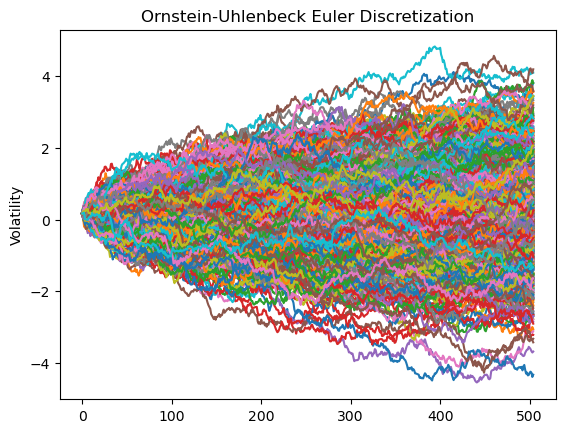

In [37]:
vol_OU = np.full(shape=(N, M), fill_value=vol0)
Z = np.random.normal(size=(N, M))
def OU_recursive(t, vol_OU):
    # Return the final state
    if t == N:
        return vol_OU
    
    # Thread the state through the recursive call
    else:
        drift_OU = kappa*(theta - vol_OU[t-1])*dt
        diffusion_OU = sigma*np.sqrt(dt)
        vol_OU[t] = vol_OU[t-1] + drift_OU + diffusion_OU*Z[t]
        return OU_recursive(t + 1, vol_OU)
    
    
start_time = time.time() 
vol_OU = OU_recursive(0, vol_OU)
print('Execution time', time.time() - start_time)
vol_OU = np.concatenate( (np.full(shape=(1, M), fill_value=vol0), vol_OU ) )
plt.plot(vol_OU)
plt.title('Ornstein-Uhlenbeck Euler Discretization')
plt.ylabel('Volatility')
plt.show()

Execution time 0.02142810821533203


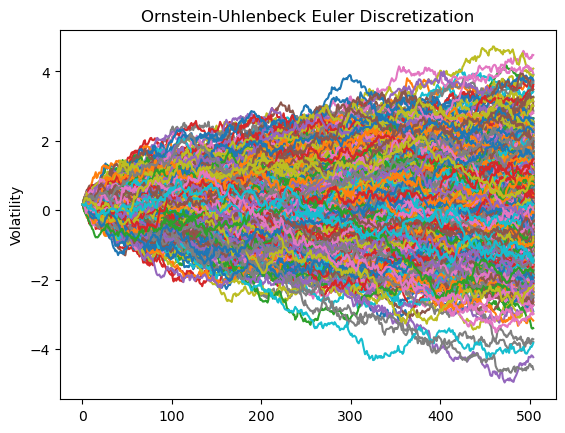

In [38]:
vol_OU = np.full(shape=(N, M), fill_value=vol0)
Z = np.random.normal(size=(N, M))
start_time = time.time()
for t in range(1,N):
    drift_OU = kappa*(theta - vol_OU[t-1])*dt
    diffusion_OU = sigma*np.sqrt(dt)
    vol_OU[t] = vol_OU[t-1] + drift_OU + diffusion_OU*Z[t]
print('Execution time', time.time() - start_time)
vol_OU = np.concatenate( (np.full(shape=(1, M), fill_value=vol0), vol_OU ) )
plt.plot(vol_OU)
plt.title('Ornstein-Uhlenbeck Euler Discretization')
plt.ylabel('Volatility')
plt.show()